In [1]:
import sys
import importlib

import numpy as np

sys.path.append("/mnt/d/aspiranture/Satellite_Imagery_Analysis/Classification/")
import dataset_tool.dataset6_generator
importlib.reload(dataset_tool.dataset6_generator)

<module 'dataset_tool.dataset6_generator' from '/mnt/d/aspiranture/Satellite_Imagery_Analysis/Classification/dataset_tool/dataset6_generator.py'>

In [2]:
dataset = dataset_tool.dataset6_generator.get_dataset6()

Error read []
len 27


In [3]:
dataset.items

<function dict.items>

In [3]:
categories_map = {}
for categorie, idx in enumerate(dataset.keys()):
    categories_map[idx] = categorie+1

In [4]:
categories_map

{'water': 1, 'forest': 2, 'fields': 3, 'city': 4, 'sands': 5, 'mountains': 6}

In [5]:
updated_dataset = {}

for key, value in dataset.items():
    print(f"shape for {key} - {value.shape}")
    numOfRects = int(value.shape[1]/64/64)
    itemsDiff = value.shape[1]-numOfRects*64*64
    numOfFull = numOfRects*64*64
    itemsToAdd = 64*64-itemsDiff
    print(f"num of rects: {numOfRects}. To make full should add: {itemsToAdd}")
    if itemsToAdd > 0:
        values_sliced = value[:,:numOfFull]
        new_value = np.concatenate([value,values_sliced],axis=1)
        print(f"created new length with shape {new_value.shape}")
        updated_dataset[key] = values_sliced
    else:
        updated_dataset[key] = value


shape for water - (12, 6596993)
num of rects: 1610. To make full should add: 1663
created new length with shape (12, 13191553)
shape for forest - (12, 1532742)
num of rects: 374. To make full should add: 3258
created new length with shape (12, 3064646)
shape for fields - (12, 2099471)
num of rects: 512. To make full should add: 1777
created new length with shape (12, 4196623)
shape for city - (12, 574996)
num of rects: 140. To make full should add: 2540
created new length with shape (12, 1148436)
shape for sands - (12, 742139)
num of rects: 181. To make full should add: 3333
created new length with shape (12, 1483515)
shape for mountains - (12, 35420)
num of rects: 8. To make full should add: 1444
created new length with shape (12, 68188)


In [6]:
y_data_list = []
x_data_list = []

for key, value in updated_dataset.items():
    category_id = categories_map[key]
    arr = np.full(value.shape[1], category_id)
    y_data_list.extend(arr)
    x_data_list.append(value)
y_data = np.asarray(y_data_list)

In [7]:
y_data.shape

(11571200,)

In [8]:
x_data_1 = np.hstack(x_data_list)

In [9]:
x_data_1.shape

(12, 11571200)

In [10]:
x_data = np.moveaxis(x_data_1, 0,1)

In [13]:
print(f"Min {x_data.min()} and max {x_data.max()}")

Min 0.0 and max 1.7788000106811523


In [14]:
x_data.shape

(11571200, 12)

In [64]:
def createImageCubes(img_array, blk_width,blk_height):
    arrray = []
    imageShape = img_array.shape
    for w in range(0,imageShape[0],blk_width):
        for h in range(0, imageShape[1], blk_height):
            arrr = img_array[w:w+blk_width,h:h+blk_height]
            arrray.append(np.asarray(arrr))
    return np.asarray(arrray)

In [14]:
y_cubes = createImageCubes(y_data, 64,64)

IndexError: tuple index out of range

In [162]:
y_data.shape

(11595776,)

In [11]:
length = int(y_data.shape[0]/64/64)
length

2825

In [12]:
y_data_cubes = y_data.reshape(length,64,64)

In [13]:
x_data_cubes = x_data.reshape(length,64,64,12)

In [14]:
import tensorflow as tf

2023-09-24 22:35:30.441469: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 22:35:32.281847: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
from tensorflow.keras.layers import *

In [94]:
model_new = tf.keras.models.Sequential([
    Conv2D(64,(5,5),padding='same',input_shape=(64,64,12)),
    Conv2D(64,(5,5),padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),

    Conv2D(128,(5,5), padding='same'),
    Conv2D(128,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2),name='feature_layer'),
    Dropout(0.5),

    #We are naming this layer, as we will extract features from it in future, JUST WAIT !!!
    Conv2D(256,(5,5), padding='same'),
    Conv2D(256,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    #Flatten(),
    #Dense(128),
    Activation('relu'),
    Dropout(0.5),
    #Reshape((4,4,128)),
    UpSampling2D((2,2)),
    Conv2D(256,(5,5), padding='same'),
    Conv2D(256,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    UpSampling2D((2,2)),
    Dropout(0.5),
    Conv2D(128,(5,5), padding='same'),
    Conv2D(128,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    UpSampling2D((2,2)),
    Dropout(0.5),
    Conv2D(64,(5,5), padding='same'),
    Conv2D(64,(5,5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(7,3,padding='same'),
    # model.add(Flatten())
    # model.add(Dense(24))
    # model.add(Activation('relu'))
    # model.add(Dropout(0.5))
    # model.add(Dense(6))
    Activation('softmax'),
])

In [95]:
model_new.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy','mse'])
model_new.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 64, 64, 64)        19264     
                                                                 
 conv2d_27 (Conv2D)          (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization_12 (Ba  (None, 64, 64, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_16 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 32, 32, 64)       

In [20]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=70,      # Random rotations between 0 and 40 degrees
    width_shift_range=0.2,  # Random horizontal shift up to 20%
    height_shift_range=0.2, # Random vertical shift up to 20%
    shear_range=0.2,        # Shear transformations
    zoom_range=0.2,         # Random zooming up to 20%
    horizontal_flip=True,   # Random horizontal flipping
    fill_mode='nearest'     # How to fill missing pixels after transformation
)

2023-09-23 22:56:05.292375: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 556597248 exceeds 10% of free system memory.


InvalidArgumentError: {{function_node __wrapped__Split_num_split_2264_device_/job:localhost/replica:0/task:0/device:GPU:0}} Number of ways to split should evenly divide the split dimension, but got split_dim 0 (size = 2831) and num_split 2264 [Op:Split] name: split

In [21]:
augmented_data = []

for img in x_data_cubes:  # Assuming x_data is your numpy array
    img = img.reshape((1,) + img.shape)  # Reshape image to (1, 64, 64, 12)
    i = 0
    for batch in datagen.flow(img, batch_size=1):  # Generate augmented images
        augmented_data.append(batch[0])
        i += 1
        if i >= 2:  # Generate 3 augmented images for each original image
            break

# Convert the augmented data back to a numpy array
augmented_data = np.array(augmented_data)


/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 64, 64, 12) (12 channels).
  warnings.warn(


In [22]:
print(f"Min {augmented_data.min()} and max {augmented_data.max()}")

Min 0.0 and max 1.5371034145355225


In [21]:
x_data_cubes.shape

(2831, 64, 64, 12)

In [23]:
x_data_combined = np.vstack((x_data_cubes, augmented_data))

In [24]:
x_data_mean = np.mean(x_data_combined)

In [25]:
x_data_std = np.std(x_data_combined)

In [16]:
x_data_stadartized = x_data_cubes/x_data_cubes.max()

In [21]:
print(f"Min {x_data_stadartized.min()} and max {x_data_stadartized.max()}")

Min 0.0 and max 1.0


In [18]:
num_toextend = x_data_combined.shape[0]/x_data_cubes.shape[0]

NameError: name 'x_data_combined' is not defined

In [19]:
y_data_augmented = np.repeat(y_data_cubes, num_toextend, axis=0)

NameError: name 'num_toextend' is not defined

In [30]:
y_data_augmented.shape

(8493, 64, 64)

In [17]:
y_data_train_cate = tf.keras.utils.to_categorical(y_data_cubes)

In [21]:
y_data_cubes.max()

6

In [22]:
y_data_train_cate.shape

(2825, 64, 64, 7)

In [18]:
tf_dataset = tf.data.Dataset.from_tensor_slices((x_data_stadartized, y_data_train_cate))

2023-09-24 22:35:58.539966: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 22:35:59.166277: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 22:35:59.166334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 22:35:59.169164: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 22:35:59.169217: I tensorflow/compile

In [19]:
DATASET_SIZE = x_data_cubes.shape[0]

train_size = int(0.8 * DATASET_SIZE)
val_size = int(0.1 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

tf_dataset = tf_dataset.shuffle(buffer_size=1000)
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [20]:
train_size

2260

In [21]:
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(128).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [100]:
history2 = model_new.fit(train_dataset, epochs=600)

Epoch 1/600


2023-09-24 11:19:27.650822: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


18/18 [==============================] - 14s 531ms/step - loss: 0.8733 - accuracy: 0.7536 - mse: 0.0560
Epoch 2/600
18/18 [==============================] - 3s 193ms/step - loss: 0.6983 - accuracy: 0.7999 - mse: 0.0442
Epoch 3/600
18/18 [==============================] - 4s 203ms/step - loss: 0.4270 - accuracy: 0.8825 - mse: 0.0282
Epoch 4/600
18/18 [==============================] - 4s 206ms/step - loss: 0.3838 - accuracy: 0.8832 - mse: 0.0251
Epoch 5/600
18/18 [==============================] - 4s 198ms/step - loss: 0.4919 - accuracy: 0.8386 - mse: 0.0327
Epoch 6/600
18/18 [==============================] - 4s 202ms/step - loss: 0.3727 - accuracy: 0.8792 - mse: 0.0250
Epoch 7/600
18/18 [==============================] - 4s 205ms/step - loss: 0.3516 - accuracy: 0.8876 - mse: 0.0242
Epoch 8/600
18/18 [==============================] - 4s 205ms/step - loss: 0.3732 - accuracy: 0.8713 - mse: 0.0264
Epoch 9/600
18/18 [==============================] - 4s 205ms/step - loss: 0.3152 - accurac

KeyboardInterrupt: 

In [36]:
testtt, = test_dataset.take(1)
pred_res = model_new.predict(testtt[0])

2023-09-24 00:51:23.413826: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1669791744 exceeds 10% of free system memory.


ValueError: in user code:

    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py", line 2283, in predict_step
        return self(x, training=False)
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 64, 64, 12), found shape=(32, 64, 12)


ValueError: too many values to unpack (expected 1)

In [79]:
test_x

(<tf.Tensor: shape=(64, 64, 12), dtype=float32, numpy=
 array([[[0.0356, 0.0502, 0.0618, ..., 0.2688, 0.1903, 0.1742],
         [0.0356, 0.0495, 0.0607, ..., 0.2708, 0.1914, 0.1816],
         [0.0353, 0.0448, 0.0566, ..., 0.269 , 0.1929, 0.1856],
         ...,
         [0.0256, 0.033 , 0.0442, ..., 0.2079, 0.1384, 0.1532],
         [0.026 , 0.0334, 0.0433, ..., 0.2054, 0.1357, 0.158 ],
         [0.0264, 0.0311, 0.0441, ..., 0.2047, 0.1328, 0.1665]],
 
        [[0.0268, 0.0339, 0.0458, ..., 0.2059, 0.1295, 0.1783],
         [0.0271, 0.0371, 0.0455, ..., 0.2072, 0.13  , 0.1784],
         [0.0275, 0.0364, 0.0472, ..., 0.2087, 0.1342, 0.1677],
         ...,
         [0.034 , 0.0371, 0.0452, ..., 0.2251, 0.1537, 0.1754],
         [0.0335, 0.0383, 0.0441, ..., 0.2211, 0.1517, 0.162 ],
         [0.0329, 0.0375, 0.0449, ..., 0.2243, 0.1516, 0.1733]],
 
        [[0.0323, 0.04  , 0.0526, ..., 0.2329, 0.1564, 0.1829],
         [0.0315, 0.0413, 0.0532, ..., 0.2431, 0.1629, 0.1913],
         [0.030

In [23]:
x_tt = []
y_tt = []

for x,y in train_dataset:
    x_tt.append(x.numpy())
    y_tt.append(y.numpy())

In [24]:
x_ttt = np.concatenate(x_tt)

In [25]:
y_ttt = np.concatenate(y_tt)

In [31]:
x_ttt.shape

(2260, 64, 64, 12)

In [105]:
y_ttt.shape

(2260, 64, 64, 7)

In [106]:
ffff = model_new.predict(x_ttt)

71/71 [==============================] - 2s 27ms/step


In [26]:
y_tttt = tf.argmax(y_ttt, axis=-1).numpy().flatten()

In [108]:
fff_t = tf.argmax(ffff, axis=-1).numpy().flatten()

In [109]:
from sklearn.metrics import accuracy_score, classification_report

accuracy_score(y_tttt, fff_t)

0.9917584174502212

In [32]:
model_new.save("dataset6_new_1.keras")

NameError: name 'model_new' is not defined

In [33]:
##TEST

In [27]:
from glob import glob
image_bands_1 = glob("/mnt/d/shared_folder/test3/*B?*.tiff", recursive=True)
image_bands_1.sort()
image_bands_1

['/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022-10-11-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 '/mnt/d/shared_folder/test3/2022-10-11-00_00_2022

In [28]:
import rasterio as rio

test_imgs_list = []

for tst_img in image_bands_1:
    with rio.open(tst_img, 'r') as img_file:
        img_array = img_file.read(1)
        test_imgs_list.append(img_array)

test_imgs_array = np.asarray(test_imgs_list)

In [31]:
print(f"Min {test_imgs_array.min()} and max {test_imgs_array.max()}")

Min 0.0 and max 0.7232000231742859


In [28]:
def createImageCubes(img_array, blk_width, blk_height):
    arrray = []
    imageShape = img_array.shape
    for w in range(0, imageShape[0], blk_width):
        for h in range(0, imageShape[1], blk_height):
            arrr = img_array[w:w + blk_width, h:h + blk_height]
            arrray.append(np.asarray(arrr))
    return np.asarray(arrray)


test_image_shape = test_imgs_array[0].shape
test_image_shape
import math

test_image_shape_0_parts = math.floor(test_image_shape[0] / 64)
test_image_shape_1_parts = math.floor(test_image_shape[1] / 64)
print(f"x: {test_image_shape_0_parts} y: {test_image_shape_1_parts}")

test_imgs_fixed_list = []
for img in test_imgs_array:
    test_img_fixed_new = img[:64*test_image_shape_0_parts, :64*test_image_shape_1_parts]
    test_imgs_fixed_list.append(test_img_fixed_new)
test_imgs_fixed_array = np.asarray(test_imgs_fixed_list)


x: 9 y: 17


In [29]:
cubes_list = []
for lstt in test_imgs_fixed_array:
    cubes = createImageCubes(lstt,64,64)
    cubes_list.append(cubes)
cubes_array = np.asarray(cubes_list)

In [30]:
cubes_array = np.moveaxis(cubes_array, 0, 3)

In [31]:
cubes_array = cubes_array/x_data_cubes.max()

In [41]:
resss = model_new.predict(cubes_array)

NameError: name 'model_new' is not defined

In [118]:
resss_pred = tf.argmax(resss, axis=-1).numpy()

In [119]:
def imageFromCube(cubes, imageWidth, imageHeight):
    arrrr = np.empty((imageWidth, imageHeight,12))
    cubesShape = cubes.shape
    items_per_row = int(imageWidth/cubesShape[1])
    items_per_col = int(imageHeight/cubesShape[2])
    for el in range(0,cubesShape[0]):
        num_row = int(el/items_per_col)
        num_col = int(el%items_per_col)
        #print("Row: ", num_row, " column: ", num_col)
        for i in range(0,cubesShape[1]):
            for j in range(0, cubesShape[2]):
                x = int(i+num_row*cubesShape[1])
                y = int(j+num_col*cubesShape[2])
                #print("X: ", x, " Y: ", y)
                arrrr[x,y] = cubes[el,i,j]
        #arrrr[num_row, num_col] = cubes[el,:, :, :]
        #num_col = int(int(el*cubesShape[1]%imageWidth)/imageHeight)
    return arrrr

In [120]:
resss_img = imageFromCube(resss_pred,576,1088)

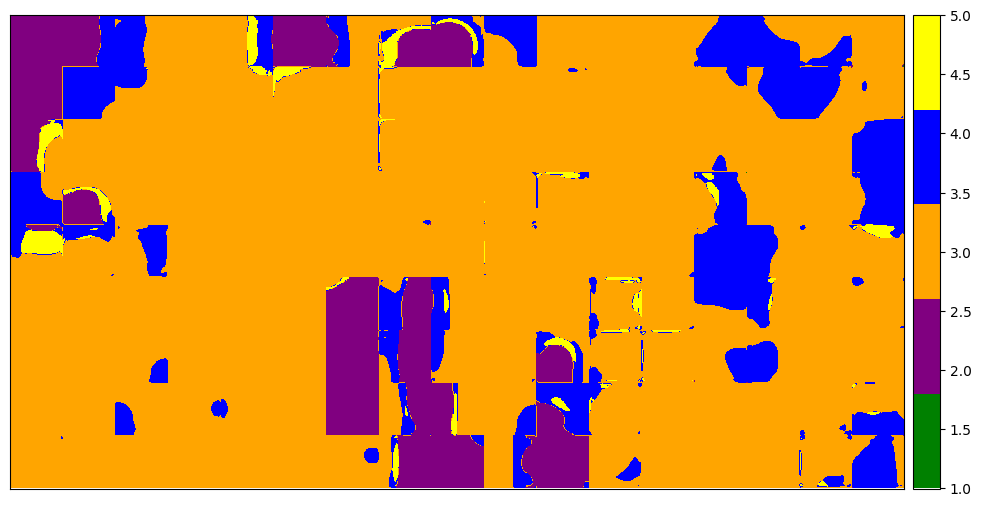

<Axes: >

In [121]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep

ep.plot_bands(resss_img[:,:,0],
              cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow']))

In [122]:
categories_map

{'water': 1, 'forest': 2, 'fields': 3, 'city': 4, 'sands': 5, 'mountains': 6}

### TRY to use naive bayes

In [232]:
import layers.naive_bayes
importlib.reload(layers.naive_bayes)
# from keras.models import Model, save_model
# from keras.layers import Input

# Create the model
# model_new_1 = tf.keras.models.Sequential()
# model_new_1.add(tf.keras.models.InputLayer(shape=(12,)))  # Input layer
# model_new_1.add(layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=7))  # Naive Bayes layer
# model_new_1.add(tf.keras.models.Softmax())  #

model_new_gnb = tf.keras.models.Sequential([
    layers.naive_bayes.MultiClassNaiveBayesLayer(num_features=12, num_of_categories=6, input_shape=(12,)),
    Activation("softmax")
    ])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')

In [233]:
model_new_gnb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mse'])
model_new_gnb.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 multi_class_naive_bayes_la  (None, 6)                 144       
 yer_5 (MultiClassNaiveBaye                                      
 sLayer)                                                         
                                                                 
 activation_29 (Activation)  (None, 6)                 0         
                                                                 
Total params: 144 (576.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 144 (576.00 Byte)
_________________________________________________________________


In [29]:
x_tain_1 = []
y_train_1 = []

for x_d, y_d in train_dataset:
    x_tain_1.append(x_d.numpy())
    y_train_1.append((y_d.numpy()))

x_train_11 = np.concatenate(x_tain_1)
y_train_11 = np.concatenate(y_train_1)

In [30]:
y_train_11.shape

(2260, 64, 64, 7)

In [31]:
x_train_111 = x_train_11.reshape(x_train_11.shape[0]*x_train_11.shape[1]*x_train_11.shape[2],12)
y_train_111 = y_train_11.reshape(x_train_11.shape[0]*x_train_11.shape[1]*x_train_11.shape[2],7)

In [169]:
y_train_11

array([[[[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
         ...,
         [0., 1., 0., ..., 0., 0., 0.],
         [0., 1., 0., ..., 0., 0., 0.],
    

In [175]:
y_train_111.shape

(9256960, 7)

In [163]:
#bayes_h = model_new_gnb.fit(x_train_111, y_train_111, epochs=1,batch_size=1024, validation_split=0.2)

7232/7232 [==============================] - 56s 8ms/step - loss: 1.9460 - accuracy: 0.0000e+00 - mse: 0.1224 - val_loss: 1.9459 - val_accuracy: 0.0000e+00 - val_mse: 0.1225


In [194]:
y_train_111.shape

(9256960, 7)

In [32]:
y_int_labels = np.argmax(y_train_111, axis=-1)
y_int_labels = y_int_labels-1
means = []
variances = []

num_classes = 6  # or however many you have

for i in range(num_classes):
    means.append(np.mean(x_train_111[y_int_labels == i], axis=0))
    variances.append(np.var(x_train_111[y_int_labels == i], axis=0))

means = np.array(means)
variances = np.array(variances)

In [33]:
x_tttt = x_ttt.reshape(x_ttt.shape[0]*x_ttt.shape[1]*x_ttt.shape[2],12)

In [225]:
means[0,:] = 0

In [226]:
variances[0,:] = 0

In [246]:
variances

array([[          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan],
       [7.5072714e-04, 7.1359624e-04, 1.3902313e-03, 3.0582945e-03,
        3.5373361e-03, 1.4280407e-03, 1.3056325e-03, 1.2161554e-03,
        9.1588026e-04, 3.5124566e-04, 2.8814946e-04, 9.3785825e-04],
       [1.3390444e-05, 1.6815497e-05, 2.4349943e-05, 2.9035853e-05,
        5.9771624e-05, 3.3204668e-04, 6.1731291e-04, 7.5976737e-04,
        5.8099267e-04, 2.6931742e-04, 9.9144927e-05, 7.7060715e-04],
       [6.6382570e-05, 1.2958462e-04, 2.0797949e-04, 4.5792671e-04,
        4.7978957e-04, 7.9541467e-04, 1.0104702e-03, 1.1524193e-03,
        1.0566724e-03, 1.0603979e-03, 1.2097897e-03, 1.1417950e-03],
       [2.3635397e-04, 5.0459383e-04, 5.1512226e-04, 6.4966630e-04,
        4.8016667e-04, 7.2053948e-04, 9.7518112e-04, 1.3310516e-03,
        9.1753475e-04, 1.0548948e-03, 8.7359

In [239]:
means

array([[0.02915865, 0.03312196, 0.03894535, 0.03473867, 0.03876298,
        0.02387872, 0.02318608, 0.0209069 , 0.01605026, 0.01059942,
        0.00965033, 0.01814351],
       [0.01150276, 0.01467091, 0.02134492, 0.01352438, 0.03531998,
        0.10759359, 0.13688509, 0.14326456, 0.15282534, 0.07436027,
        0.03238188, 0.15238105],
       [0.0272764 , 0.03468506, 0.04632021, 0.05880858, 0.07405695,
        0.09216123, 0.10208715, 0.11047029, 0.1162836 , 0.15326554,
        0.12305496, 0.1156451 ],
       [0.03545165, 0.04030988, 0.04910934, 0.05284545, 0.06868093,
        0.09916554, 0.11136083, 0.11593673, 0.12217683, 0.12035356,
        0.09544441, 0.12089972],
       [0.09082571, 0.11970866, 0.17434332, 0.23805812, 0.26639113,
        0.27266017, 0.28622344, 0.29023218, 0.3006949 , 0.3668648 ,
        0.3540075 , 0.29408118],
       [0.03951728, 0.04714312, 0.06380208, 0.07952226, 0.09414418,
        0.10468826, 0.11244895, 0.12240051, 0.1254742 , 0.20080724,
        0.16093574,

In [197]:
model_new_gnb.layers

In [234]:
model_new_gnb.layers[0].set_weights([means, variances])

In [261]:
model_new_gnb.save("model_gnb.keras")

In [240]:
nb_pred_res = model_new_gnb.predict(x_tttt, batch_size=2048)

4520/4520 [==============================] - 18s 4ms/step


In [241]:
nb_pres_res_1 = tf.argmax(nb_pred_res,axis=-1).numpy()

In [242]:
nb_pres_res_1.max()

5

In [248]:
y_testtt = y_tttt - 1

In [249]:
accuracy_score(y_testtt, nb_pres_res_1.flatten())

0.8536017223797013

In [244]:
y_tttt.shape

(9256960,)

In [250]:
test_imgs_array.shape

(12, 638, 1094)

In [32]:
test_arr_nb = test_imgs_array/x_data_cubes.max()

In [33]:
test_arr_nb = np.moveaxis(test_arr_nb, 0, 2)

In [34]:
test_arr_nb.shape

(638, 1094, 12)

In [35]:
test_arr_to_pred = test_arr_nb.reshape(test_arr_nb.shape[0]*test_arr_nb.shape[1],12)

In [255]:
test_arr_nb_pred_res = model_new_gnb.predict(test_arr_to_pred,batch_size=2048)

341/341 [==============================] - 1s 4ms/step


In [256]:
test_arr_nb_pred = tf.argmax(test_arr_nb_pred_res, axis=-1)

In [259]:
test_arr_nb_pred_ss = test_arr_nb_pred.numpy().reshape(638,1094)

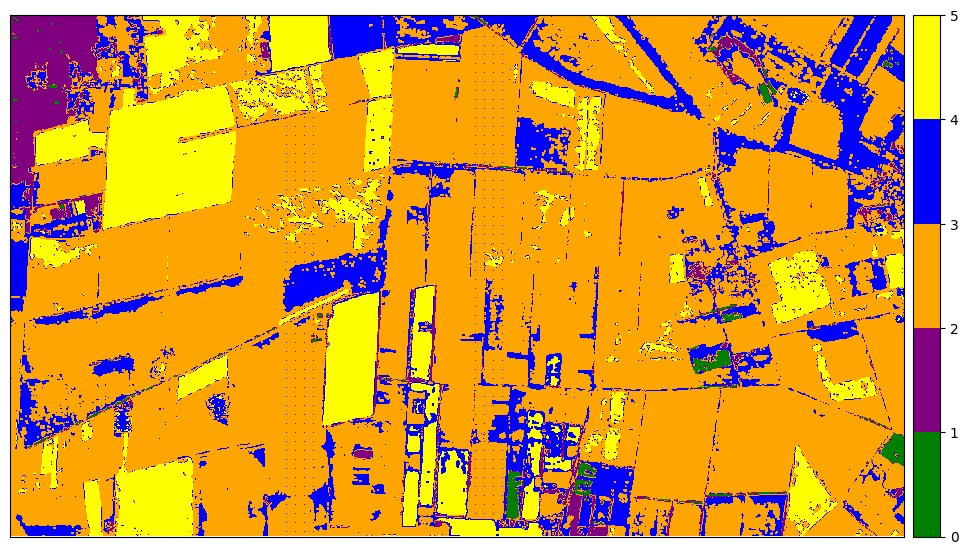

<Axes: >

In [260]:
from matplotlib.colors import ListedColormap
import earthpy.plot as ep

ep.plot_bands(test_arr_nb_pred_ss,
              cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow']))

In [262]:
categories_map

{'water': 1, 'forest': 2, 'fields': 3, 'city': 4, 'sands': 5, 'mountains': 6}

### Test KNNC

In [293]:
y_train_111.shape

(9256960, 7)

In [34]:
import layers.knnc
importlib.reload(layers.knnc)
# model_new_knn = tf.keras.models.Sequential([
#     layers.knnc.KNNLayer(k=3, num_classes=6,input_shape=(12,)),
#     Activation("softmax")
#     ])

# Sample usage

model_knnc = tf.keras.models.Sequential([
    layers.knnc.KNNClassifierLayer2(k=3,X_train = x_train_111, y_train = y_int_labels, input_shape=(12,)),
    Activation("softmax")
])

# Assuming you've trained or set the weights, you can then save the model:
#save_model(model, 'naive_bayes_model.h5')

In [62]:
importlib.reload(layers.knnc)

<module 'layers.knnc' from '/mnt/d/aspiranture/Satellite_Imagery_Analysis/Classification/layers/knnc.py'>

In [35]:
model_knnc.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy','mse'])
model_knnc.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 knn_classifier_layer2 (KNN  (None, 6)                 0         
 ClassifierLayer2)                                               
                                                                 
 activation (Activation)     (None, 6)                 0         
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model_knnc.save("kncc.h5", save_format='h5')

/home/andrew/miniconda3/envs/segmentation-new/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [69]:
predictions_knnc = model_knnc.predict(test_arr_to_pred, batch_size=512)

   1/1364 [..............................] - ETA: 3:29

2023-09-24 21:18:12.386453: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } attr { key: "_has_manual_control_dependencies" value { b: true } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA GeForce RTX 3090" frequency: 1740 num_cores: 82 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11080" } environment { key: "cudnn" value: "8600" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 22842179584 bandwidth: 936096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1364/1364 [==============================] - 166s 122ms/step


In [70]:
predictions_knnc.shape

(697972, 6)

NameError: name 'test_arr_knn_pred_ss' is not defined

In [2]:
test_arr_knn_pred = tf.argmax(predictions_knnc, axis=-1)
test_arr_knn_pred_ss = test_arr_knn_pred.numpy().reshape(638, 1094)
from matplotlib.colors import ListedColormap
import earthpy.plot as ep

test_arr_knn_pred_ss = test_arr_knn_pred_ss + 1

ep.plot_bands(test_arr_knn_pred_ss,
              cmap=ListedColormap(['green', 'purple', 'orange', 'blue', 'yellow']))

NameError: name 'tf' is not defined